In [1]:
import os
import torch
from YOLO import *
from label_map import *
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
%matplotlib inline

## Load Datasets and Model

In [2]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
model_dir = 'YOLO/cfg/'
test_file = 'YOLO_Pretrained'

# Load Dataset
dataset = PascalVOCDataloader(data_dir, normalize=True, YOLO=True)
train_loader, val_loader, test_loader = create_split_loaders(dataset,batch_size=1)

# Load Model
#faster_rcnn = FasterRCNNVGG16()
yolo = Darknet("YOLO/cfg/yolov3.cfg")
yolo.load_weights("YOLO/yolov3.weights")
#trainer = FasterRCNNTrainer(faster_rcnn).cuda()
#trainer.load(model_dir+'fasterrcnn_12211511_0.701052458187_torchvision_pretrain')
img, q, e = next(iter(val_loader))

det = yolo(img, CUDA=False)

op = write_results(det,0.5,80,0.4)
_bboxes = op[:,1:5]
_labels = op[:,-1]
_scores = op[:,-2]
print(_bboxes)
#_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes),
         at.tonumpy(_labels).reshape(-1),
         at.tonumpy(_scores).reshape(-1))

ValueError: too many values to unpack (expected 3)

In [ ]:
op = write_results(det,0.5,80,0.4)
print(op.shape)
print(_bboxes)
print(det.shape)
_bboxes = op[:,1:5]
_labels = op[:,-1]
_scores = op[:,-2]

true_bboxes, true_labels, = true_bboxes.numpy()[0], true_labels.numpy()[0]
    true_bboxes[:,[0, 2]] = (416/height.numpy()[0])*true_bboxes[:,[0, 2]] 
    true_bboxes[:,[1, 3]] = (416/width.numpy()[0])*true_bboxes[:,[1, 3]]

for idx,l in enumerate(pred_labels):
    _labels[idx] = coco_to_pascal[l]
print(_labels.shape, _bboxes.shape, _scores.shape)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes),
         at.tonumpy(_labels).reshape(-1),
         at.tonumpy(_scores).reshape(-1))


## Evaluate and Save Testing Outputs

In [27]:
import pandas as pd
n_classes = 20
class_labels = [ 1, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18]

### Load Results into Dataframe ###
PRED_COL = ['img_num', 'pred_bboxes', 'pred_labels', 'pred_scores']
Predicted_Data = pd.DataFrame(columns=PRED_COL)
TRUE_COL = ['img_num', 'true_bboxes', 'true_labels']
True_Data = pd.DataFrame(columns=TRUE_COL)
n_pred_bboxes = 0
n_pred_thresh = 300
class_check = np.zeros((n_classes))
import time


for img_num, (img, true_bboxes, true_labels, height, width) in enumerate(test_loader, 0):
    true_bboxes, true_labels, = true_bboxes.numpy()[0], true_labels.numpy()[0]
    true_bboxes[:,[0, 2]] = (416/height.numpy()[0])*true_bboxes[:,[0, 2]] 
    true_bboxes[:,[1, 3]] = (416/width.numpy()[0])*true_bboxes[:,[1, 3]]
    
    start_time = time.time()
    det = yolo(img, CUDA=False)
    output = write_results(det,0.5,80,0.4)
    if not isinstance(output, int):
        #print(output)
        #print('Epoch', start_time - time.time())
        pred_bboxes = output[:,1:5]
        pred_labels = output[:,-1]
        pred_scores = output[:,-2]
        #print(pred_labels)
        for idx,l in enumerate(pred_labels):
            #print(type(int(l.item())))
            pred_labels[idx] = coco_to_pascal[int(l.item())]
        #print(pred_labels)
        #pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.45) # YOLO model pred
        pred_bboxes, pred_labels, pred_scores = np.asarray(pred_bboxes), np.asarray(pred_labels), np.asarray(pred_scores)

        n_pred = pred_bboxes.shape[0]
        #print('Pred')
        for i in range(n_pred):
            #print(pred_bboxes[i])
            tmp_df = pd.DataFrame([[img_num, pred_bboxes[i], pred_labels[i], pred_scores[i]]], columns=PRED_COL) # COCO to PAs
            Predicted_Data = Predicted_Data.append(tmp_df, ignore_index=True)
        n_true = true_bboxes.shape[0]
        #print('True')
        for i in range(n_true):
            #print(true_bboxes[i])
            tmp_df = pd.DataFrame([[img_num, true_bboxes[i], true_labels[i]]], columns=TRUE_COL)
            True_Data = True_Data.append(tmp_df, ignore_index=True)
            class_check[true_labels[i]] = 1
        n_pred_bboxes += pred_bboxes.shape[0]
        cc = class_check[class_labels]
        print(n_pred_bboxes, np.sum(cc))
        if (n_pred_bboxes > n_pred_thresh) and (np.sum(cc) == len(class_labels)):
            print('Test conditions reached with %d test images and %d predicted boxes' % (img_num, n_pred_bboxes))
            break

        Predicted_Data.to_pickle(test_file+'_Predicted_Data.pkl')
        True_Data.to_pickle(test_file+'_True_Data.pkl')
print(Predicted_Data.shape[0])


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


1 0.0
3 2.0
4 3.0
6 5.0
8 6.0
10 6.0
13 6.0
19 6.0
21 6.0
22 6.0
25 6.0
26 7.0
27 8.0
28 8.0
30 8.0
31 8.0
32 8.0
33 8.0
35 8.0
37 8.0
40 8.0
43 9.0
46 9.0
48 9.0
50 9.0
54 9.0
55 9.0
60 9.0
62 9.0
64 9.0
72 9.0
73 9.0
78 9.0
81 9.0
83 9.0
84 9.0
90 9.0
93 9.0
95 9.0
103 9.0
105 9.0
108 9.0
119 9.0
121 9.0
128 9.0
131 9.0
140 9.0
143 9.0
144 9.0
147 9.0
149 9.0
151 9.0
153 9.0
155 9.0
156 9.0
158 9.0
166 9.0
172 9.0
173 9.0
178 9.0
179 9.0
181 9.0
182 9.0
187 10.0
190 10.0
193 10.0
197 10.0
198 10.0
199 10.0
200 10.0
201 10.0
203 10.0
215 10.0
216 10.0
220 10.0
222 10.0
224 10.0
225 10.0
227 10.0
229 10.0
230 10.0
232 10.0
233 10.0
239 10.0
241 10.0
245 10.0
250 10.0
252 10.0
255 10.0
258 10.0
270 10.0
272 10.0
276 10.0
277 10.0
278 10.0
279 10.0
280 10.0
289 10.0
294 10.0
301 10.0
307 10.0
309 10.0
311 10.0
312 10.0
313 10.0
314 10.0
316 10.0
318 10.0


KeyboardInterrupt: 

In [28]:
Predicted_Data.to_pickle(test_file+'_Predicted_Data.pkl')
True_Data.to_pickle(test_file+'_True_Data.pkl')

In [29]:
print(len(Predicted_Data))

318


## Calculate Precision and Recall

In [29]:
from IoU import bb_intersection_over_union
Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
#print(Predicted_Data)
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')
#True_Data.to_pickle('RCNN_True_Data.pkl')
print(len(Predicted_Data))
#Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=True)
#Predicted_Data.reset_index(inplace=True)
#print(Predicted_Data[:4])
#print(True_Data['true_labels'].value_counts())
class_labels = [ 1, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18]

def calc_precision_recall(Predicted_Data, True_Data, class_labels):
    Predicted_Data = Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=False)
    Predicted_Data = Predicted_Data.reset_index(inplace=False)
    n_classes = len(class_labels)
    mAP_thresh = 0
    
    n_pred = Predicted_Data.shape[0]
    Precision = np.zeros((n_pred))
    Recall = np.zeros((n_pred))
    TP_FN = True_Data['true_labels'].value_counts()
    print(TP_FN)
    for p in range(1,n_pred+1):
        pred_data = Predicted_Data[:p]
        class_precision = []
        class_recall = []
        for c in range(n_classes):
            cl = class_labels[c]
            if  not(TP_FN.keys().contains(cl)):
                #print('class not contained in true keys')
                continue
            #cl = class_labels[c]
            #print('Class = ', cl)
            pred_data_cl = pred_data.loc[pred_data['pred_labels'] == cl]
            #print(pred_data_cl)
            #print(pred_data['pred_labels'], type(cl))
            n_bboxes = pred_data_cl.shape[0]
            TP = 0
            FP = 0
            # Check if positives are True or False
            for _,pred_row in pred_data_cl.iterrows():
                #print('ROW of pred entered!!!!!!!!')
                pred_bbox = pred_row['pred_bboxes']
                img_num = pred_row['img_num']
                true_data = True_Data.loc[True_Data['img_num'] == img_num]
                true_data = true_data.loc[true_data['true_labels'] == cl]
                
                n_true_bboxes = true_data.shape[0]
                # Calculate iou between ground truth and predictions
                max_iou = 0
                #print('Image Number = ', img_num)
                for _,true_row in true_data.iterrows():
                    true_bbox = true_row['true_bboxes']
                    #print(pred_bbox)
                    #print(img_num, true_bbox)
                    #iou = bb_intersection_over_union(pred_bbox, true_bbox)
                    iou = bb_intersection_over_union(true_bbox, pred_bbox)
                    if (iou > max_iou):
                        max_iou = iou
                        print('IOU=',iou)
                        print(pred_bbox)
                        print(true_bbox)
                if (max_iou >= mAP_thresh):
                    TP += 1
                elif (max_iou < mAP_thresh):
                    FP += 1
            if (n_bboxes > 0):
                class_precision.append(TP/(TP+FP))
                class_recall.append(TP/TP_FN[cl])
        if(len(class_precision) > 0):
            Precision[p-1] = sum(class_precision)/len(class_precision)
            Recall[p-1] = sum(class_recall)/len(class_recall)

    return Precision, Recall

Precision, Recall = calc_precision_recall(Predicted_Data, True_Data, class_labels)
np.save(test_file+'_Precision.npy', Precision) 
np.save(test_file+'_Recall.npy', Recall)
#TP_FN = True_Data['true_labels'].value_counts()
#print(type(TP_FN), TP_FN.keys().contains(9))
print(Precision, Recall)

318
14    91
8     26
19    15
11    14
6     13
4     12
17    10
16    10
0      8
12     8
9      7
3      7
10     7
7      5
1      5
15     4
18     3
13     3
2      3
Name: true_labels, dtype: int64
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.2981709094916741
[176.10252 14

IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU=

IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]


IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]


IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.08410328617539757
[ 23.310581 218.69693  149.50629  340.87186 ]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.

[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.08410328617539757
[ 23.310581 218.69693  149.50629  340.87186 ]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.415

IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  ]
IOU= 0.12977431253652016
[180.19205 187.82396 409.11386 373.02258]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.08410328617539757
[ 23.310581 218.69693  149.50629  340.87186 ]
[ 70.48889 188.06667 288.88892 245.26666]
IOU= 0.1571294007157453
[ -3.320343  -4.078354 145.57481  172.47736 ]
[ 14.421332   0.       357.20532  412.672   ]
IOU= 0.2981709094916741
[176.10252 145.95012 259.56195 292.99512]
[ 97.62133 181.376   261.80264 242.112  ]
IOU= 0.046425949075313645
[124.03551 183.84402 156.07906 255.4158 ]
[ 26.384777 122.304    396.65115  250.432   ]
IOU= 0.059480891089962594
[124.03551 183.84402 156.07906 255.4158 ]
[124.88795 230.464   315.73782 294.528  

## Plot Total PR Curve and Calculate mAP

0.7272727272727273


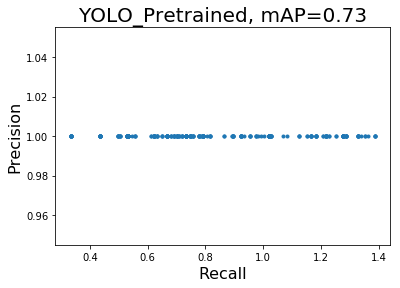

In [30]:
from matplotlib import pyplot as plt

#print(Recall[Recall > 0])
#print(Precision, Recall)
def calculate_mAP(Recall, Precision):
    N = Precision.shape[0]
    # Smooth precision curve
    for i in range(N-1):
        ind_right = (Recall >= Recall[i])
        Precision[i] = max(Precision[i], np.max(Precision[ind_right]))
    # Interpolate PR values
    recall_steps = np.linspace(0,1,11)
    Interp_Precision = np.zeros(11)
    for i in range(11):
        r = recall_steps[i]
        ind_closest = np.argmin(np.absolute(r - Recall))
        if (np.absolute(Recall[ind_closest] - r) <= 0.1):
            Interp_Precision[i] = Precision[ind_closest]
            Recall[ind_closest] = 0
    mAP = np.sum(Interp_Precision)/11
    return mAP

Precision = np.load(test_file+'_Precision.npy') 
Recall = np.load(test_file+'_Recall.npy')
Precision = Precision[Recall > 0]
Recall = Recall[Recall > 0]
mAP = calculate_mAP(Recall.copy(), Precision.copy())
print(mAP)
fig = plt.figure()
plt.plot(Recall[Recall > 0], Precision[Recall > 0], '.')
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.title(test_file+', mAP=%.2f' %(mAP),fontsize=20)
fig.savefig('plot/'+test_file+'_PR.png')

## Plot Class Specific PR Curves

In [ ]:
from matplotlib import pyplot as plt

Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')


classes = {0:'Aeroplane', 1:'Bicycle',2:'Bird',3:'Boat',4:'Bottle',5:'Bus',
                        6:'Car', 7:'Cat',8:'Chair',9:'Cow',10:'Diningtable',11:'Dog',
                        12:'Horse', 13:'Motorbike',14:'Person',15:'Potted Plant',
                        16:'Sheep', 17:'Sofa',18:'Train',19:'Tv Monitor'}
# Plot Precision Recall for each class
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(20)
i = 1
for c in class_labels:
    P,R = calc_precision_recall(Predicted_Data, True_Data, [c])
    mAP = calculate_mAP(R[R>0].copy(), P[R>0].copy())
    plt.subplot(3, 4, i)
    plt.plot(R[R>0], P[R>0], '.')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title(' Class = '+ classes[c]+', mAP=%.2f' %(mAP),fontsize=20)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.tight_layout()
    i += 1
plt.show()
fig.savefig('plot/'+test_file+'_Class_PR.png')